In [1]:
import sys
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Read all files

In [11]:
tk = th.Thicket.from_caliperreader(glob("cali/*/*.cali"))

(2/2) Creating Thicket: 100%|██████████| 617/617 [00:03<00:00, 160.87it/s]
c:\Users\Surya\Documents\TAMU\TAMU_Y3S1\CSCE 435\.venv\Lib\site-packages\thicket\ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({numerical_fill_value: None}, inplace=True)


View Calltree

In [12]:
print(tk.tree(metric_column="Avg time/rank"))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2024.1.0

0.555 main
├─ 0.022 MPI_Comm_dup
│  └─ nan MPI_Comm_dup
├─ 0.000 MPI_Finalize
│  ├─ nan MPI_Comm_dup
│  ├─ nan MPI_Finalize
│  ├─ nan MPI_Finalized
│  └─ nan MPI_Initialized
├─ 0.000 MPI_Finalized
├─ 0.000 MPI_Init
│  └─ nan MPI_Init
├─ 0.000 MPI_Initialized
├─ 0.002 comm
│  ├─ nan MPI_Barrier
│  └─ 0.002 comm_large
│     ├─ nan MPI_Recv
│     ├─ 0.001 MPI_Reduce
│     └─ nan MPI_Send
├─ nan comm_large
│  └─ nan MPI_Scatterv
├─ 0.005 comp
│  └─ 0.005 comp_large
├─ nan comp_large
│  └─ nan MPI_Gatherv
├─ 0.002 correctness_check
└─ 0.000 data_init_runtime

Legend (Metric: Avg time/rank Min: 0.00 Max: 0.56 indices: {'profile': np.int64(6431019)})
█ 0.50 - 0.56
█ 0.39 - 0.50
█ 0.28 - 0.39
█ 0.17 - 0.28
█ 0.06 - 0.17
█ 0.00 - 0.06

name User code    ◀  Only in left graph    ▶  Only in right graph



In [13]:
extracted_md = tk.metadata[['algorithm', 'programming_model', 'data_type', 'size_of_data_type', 
          'input_size', 'input_type', 'num_procs', 'scalability', 
          'group_num', 'implementation_source']]
print(extracted_md.to_markdown(index=False))

| algorithm   | programming_model   | data_type   |   size_of_data_type |   input_size | input_type     |   num_procs | scalability   |   group_num | implementation_source   |
|:------------|:--------------------|:------------|--------------------:|-------------:|:---------------|------------:|:--------------|------------:|:------------------------|
| radix       | mpi                 | int         |                   4 |       262144 | Reverse Sorted |           8 | strong        |           5 | handwritten             |
| bitonic     | mpi                 | int         |                   4 |      4194304 | random         |          64 | strong        |           5 | handwritten             |
| radix       | mpi                 | int         |                   4 |      1048576 | Reverse Sorted |           4 | strong        |           5 | handwritten             |
| radix       | mpi                 | int         |                   4 |       262144 | 1% Perturbed   |           4 | 

Extract `algorithm`, `num_procs`, `input_size`, and `input_type` from metadata and inject into dataframe as columns.

In [14]:
tk.metadata_column_to_perfdata("algorithm")
tk.metadata_column_to_perfdata("num_procs")
tk.metadata_column_to_perfdata("input_size")
tk.metadata_column_to_perfdata("input_type")

tk.dataframe = tk.dataframe.reset_index().set_index(["algorithm", "num_procs", "input_size", "input_type"]).sort_index()

In [15]:
perfdata = tk.dataframe.where(tk.dataframe['name'] == 'comp_large')
perfdata = perfdata.reset_index()
perfdata = perfdata[perfdata['profile'].notna()]
display(perfdata.head())

,algorithm,num_procs,input_size,input_type,node,profile,nid,spot.channel,Min time/rank,Max time/rank,Avg time/rank,Total time,Variance time/rank,Min time/rank (exc),Max time/rank (exc),Avg time/rank (exc),Total time (exc),Calls/rank (min),Calls/rank (avg),Calls/rank (max),Calls/rank (total),name
21,bitonic,2,65536,perturbed,"{'name': 'comp_large', 'type': 'function'}",3.655061e+09,6.0,regionprofile,0.022897,0.028040,0.025468,0.050936,0.000007,0.022897,0.028040,0.025468,0.050936,1.0,1.5,2.0,3.0,comp_large
47,bitonic,2,65536,random,"{'name': 'comp_large', 'type': 'function'}",1.352121e+09,6.0,regionprofile,0.028188,0.033607,0.030898,0.061796,0.000007,0.028188,0.033607,0.030898,0.061796,1.0,1.5,2.0,3.0,comp_large
73,bitonic,2,65536,reverse,"{'name': 'comp_large', 'type': 'function'}",1.488322e+08,6.0,regionprofile,0.022342,0.027976,0.025159,0.050319,0.000008,0.022342,0.027976,0.025159,0.050319,1.0,1.5,2.0,3.0,comp_large
99,bitonic,2,65536,sorted,"{'name': 'comp_large', 'type': 'function'}",8.242827e+08,6.0,regionprofile,0.024519,0.029875,0.027197,0.054394,0.000007,0.024519,0.029875,0.027197,0.054394,1.0,1.5,2.0,3.0,comp_large
125,bitonic,2,262144,perturbed,"{'name': 'comp_large', 'type': 'function'}",3.184030e+08,6.0,regionprofile,0.114094,0.137977,0.126035,0.252071,0.000143,0.114094,0.137977,0.126035,0.252071,1.0,1.5,2.0,3.0,comp_large


In [16]:
tk.dataframe.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 16068 entries, ('bitonic', np.int64(2), np.int64(65536), 'perturbed') to ('radix', np.int64(1024), np.int64(268435456), 'Sorted')
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   node                 16068 non-null  object 
 1   profile              16068 non-null  int64  
 2   nid                  9014 non-null   float64
 3   spot.channel         9014 non-null   object 
 4   Min time/rank        9014 non-null   float64
 5   Max time/rank        9014 non-null   float64
 6   Avg time/rank        9014 non-null   float64
 7   Total time           9014 non-null   float64
 8   Variance time/rank   9014 non-null   float64
 9   Min time/rank (exc)  9014 non-null   float64
 10  Max time/rank (exc)  9014 non-null   float64
 11  Avg time/rank (exc)  9014 non-null   float64
 12  Total time (exc)     9014 non-null   float64
 13  Calls/rank (min)     8326 non-nu

In [17]:
import os

def save_fig(path : str, filename : str):
    path_dirs = path.split('/')
    for i in range(len(path_dirs)):
        intermediate_path = '/'.join(path_dirs[:i+1])
        if not os.path.exists(intermediate_path):
            os.mkdir(intermediate_path)
    plt.savefig(os.path.join(path, filename))

def plot_rank_times(input_size: int, df_by_size: pd.DataFrame, input_types: list, algorithm: str, show=True, save=False):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Impact of Processors on Time / Rank (Input Size = {input_size})')

    for i, input_type in enumerate(input_types):
        df_by_type = df_by_size[df_by_size['input_type'] == input_type]

        num_procs = df_by_type['num_procs']
        min_time = df_by_type['Min time/rank']
        avg_time = df_by_type['Avg time/rank']
        max_time = df_by_type['Max time/rank']

        ax = axs[i // 2, i % 2]
        ax.plot(num_procs, min_time, label='Min time/rank', marker='o')
        ax.plot(num_procs, avg_time, label='Avg time/rank', marker='o')
        ax.plot(num_procs, max_time, label='Max time/rank', marker='o')

        ax.set_title(f'Input Type: {input_type}')
        ax.set_xlabel('Number of Processors')
        ax.set_ylabel('Time (s)')
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save:
        save_fig(f'plots/{algorithm}', f'{algorithm}_performance_rank_a{input_size}.png')
    if show:
        plt.show()

def plot_total_time(input_size: int, df_by_size: pd.DataFrame, input_types: list, algorithm: str, show=True, save=False):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(f'Impact of Processors on Total Time (Input Size = {input_size})')
    
    for input_type in input_types:
        df_by_type = df_by_size[df_by_size['input_type'] == input_type]
        total_time = df_by_type.groupby('num_procs')['Total time'].mean()
        ax.plot(total_time.index, total_time.values, label=f'Total time ({input_type})', marker='o')

    ax.set_xlabel('Number of Processors')
    ax.set_ylabel('Time (s)')
    ax.legend()
    plt.tight_layout()
    if save:
        save_fig(f'plots/{algorithm}', f'{algorithm}_performance_total_a{input_size}.png')
    if show:
        plt.show()

def plot_variance_time(input_size: int, df_by_size: pd.DataFrame, input_types: list, algorithm: str, show=True, save=False):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(f'Impact of Processors on Variance Time/Rank (Input Size = {input_size})')
    
    for input_type in input_types:
        df_by_type = df_by_size[df_by_size['input_type'] == input_type]
        variance_time = df_by_type.groupby('num_procs')['Variance time/rank'].mean()
        ax.plot(variance_time.index, variance_time.values, label=f'Variance time ({input_type})', marker='o')

    ax.set_xlabel('Number of Processors')
    ax.set_ylabel('Time (s)')
    ax.legend()
    plt.tight_layout()
    if save:
        save_fig(f'plots/{algorithm}', f'{algorithm}_performance_variance_a{input_size}.png')
    if show:
        plt.show()

def plot_process_performance(perfdata : pd.DataFrame, algorithm : str, show=True, save=False):
    bitonic_df = perfdata[perfdata['algorithm'] == algorithm]
    
    input_sizes = bitonic_df['input_size'].unique()
    input_types = bitonic_df['input_type'].unique()

    for input_size in input_sizes:
        df_by_size = bitonic_df[bitonic_df['input_size'] == input_size]
        
        plot_rank_times(input_size, df_by_size, input_types, algorithm, show, save)
        plot_total_time(input_size, df_by_size, input_types, algorithm, show, save)
        plot_variance_time(input_size, df_by_size, input_types, algorithm, show, save)


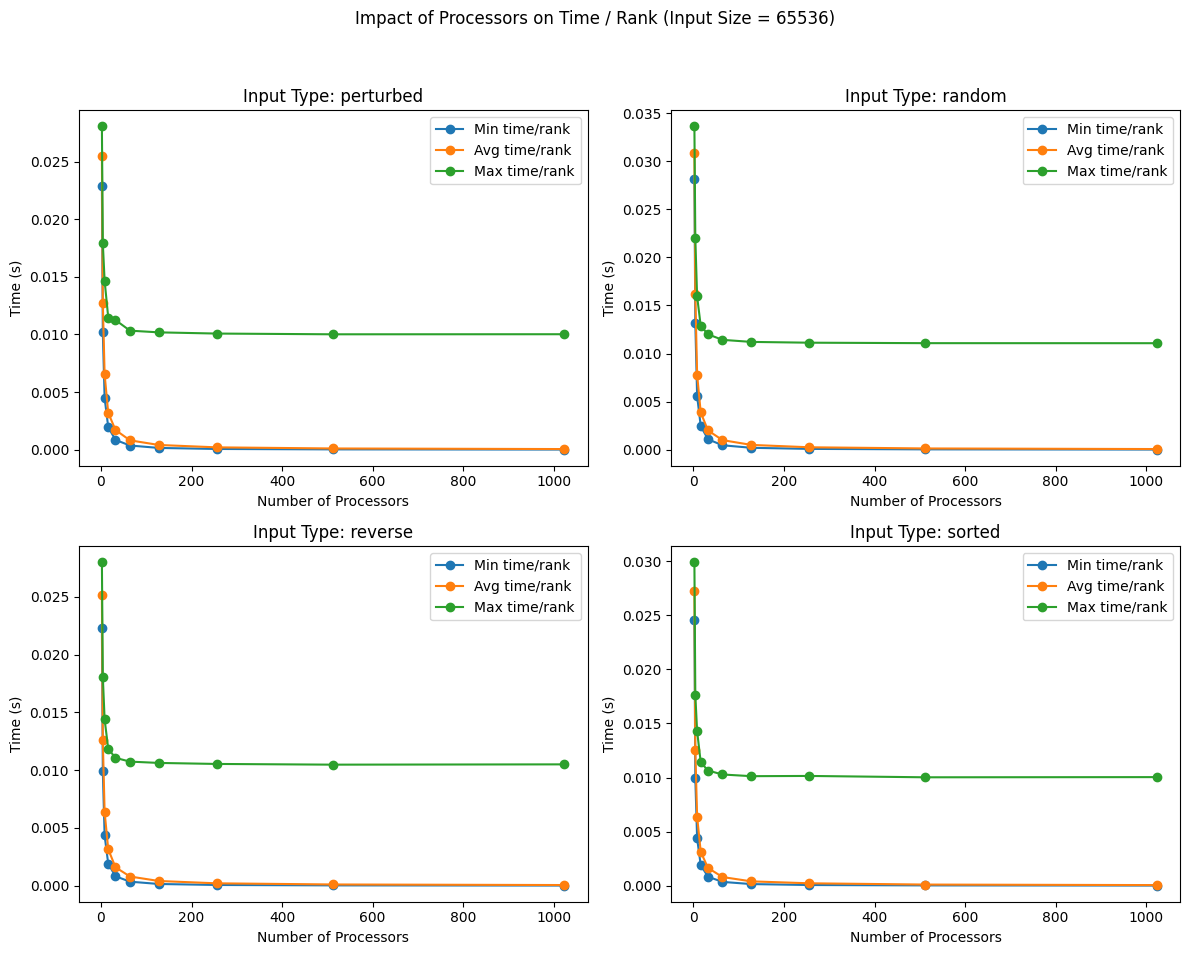

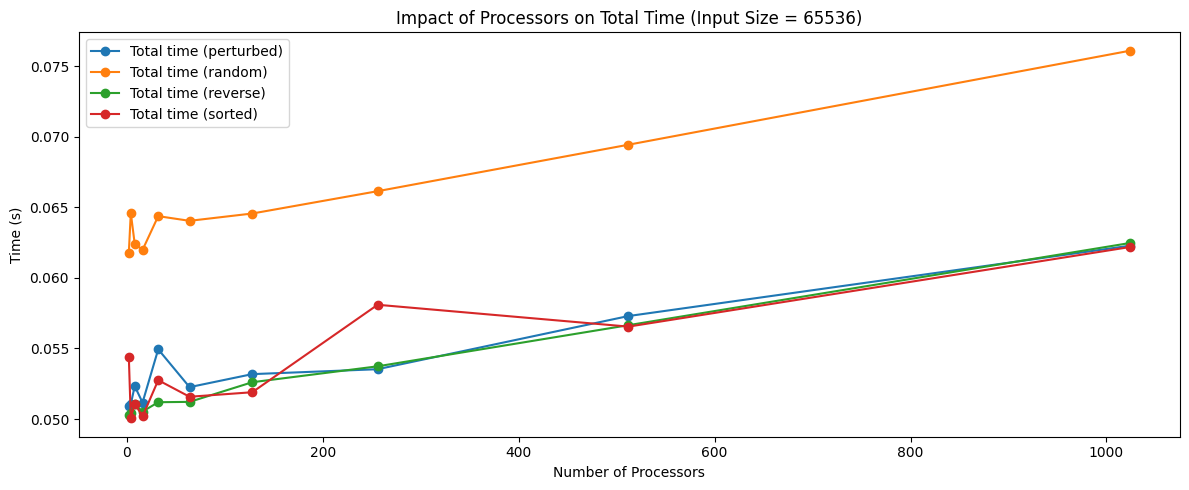

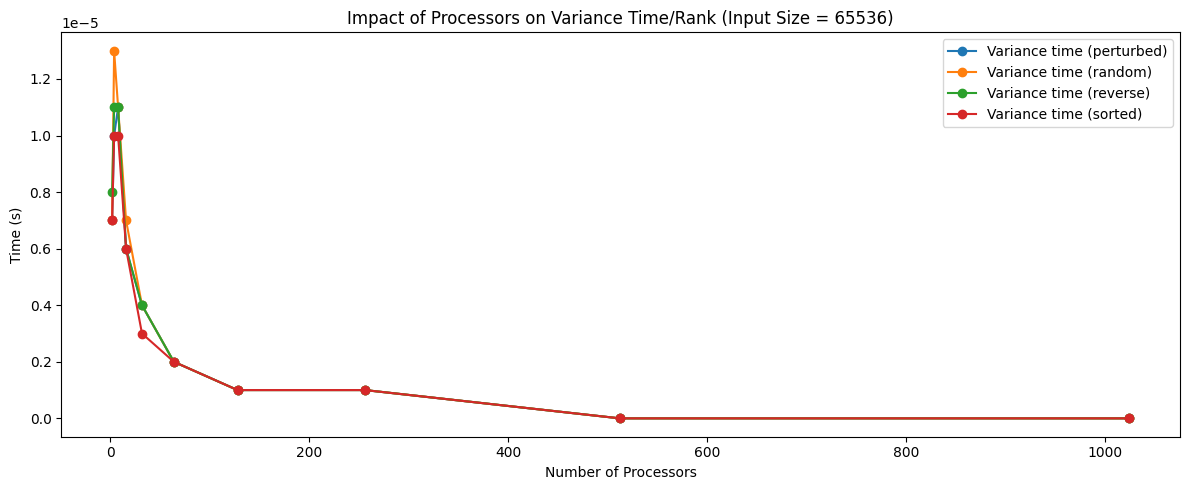

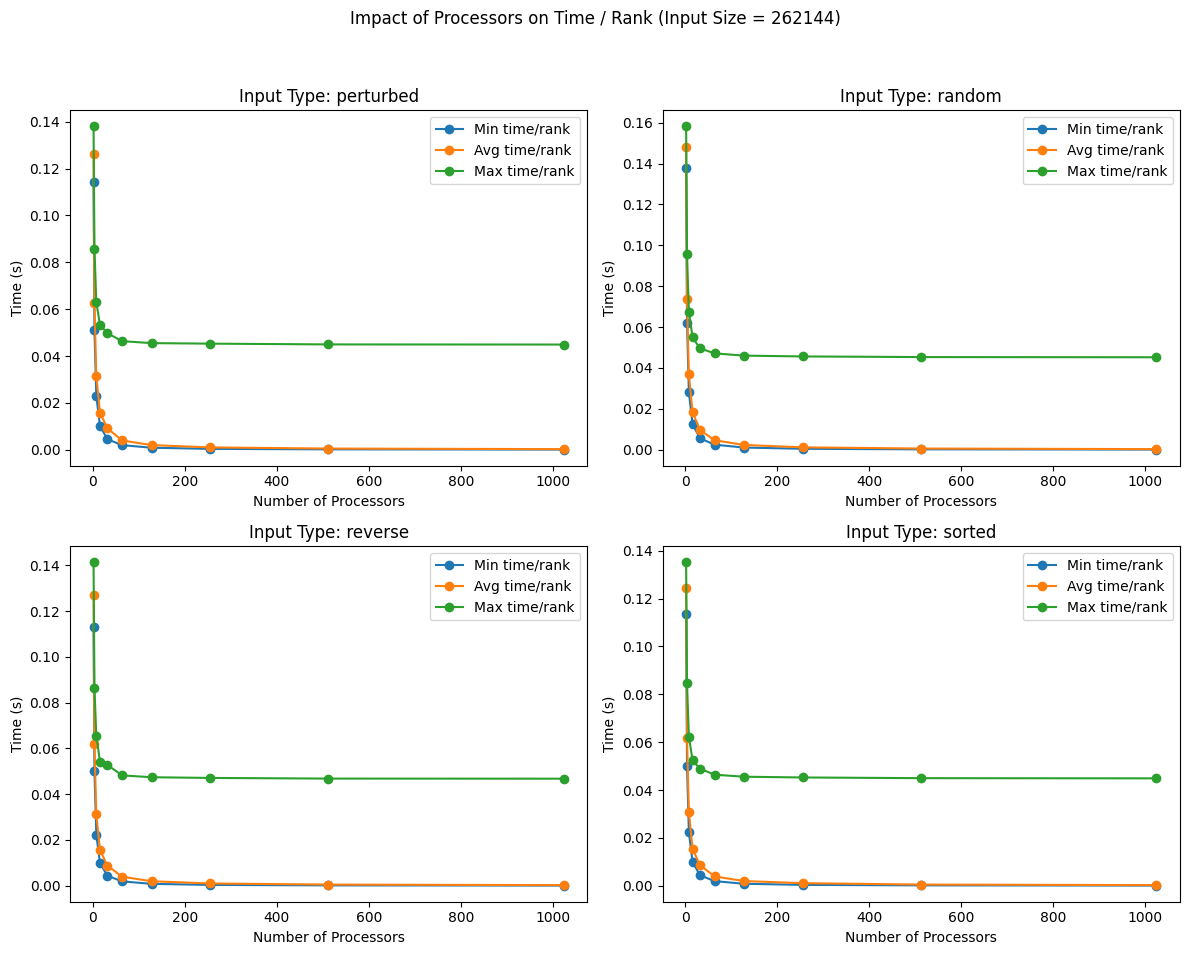

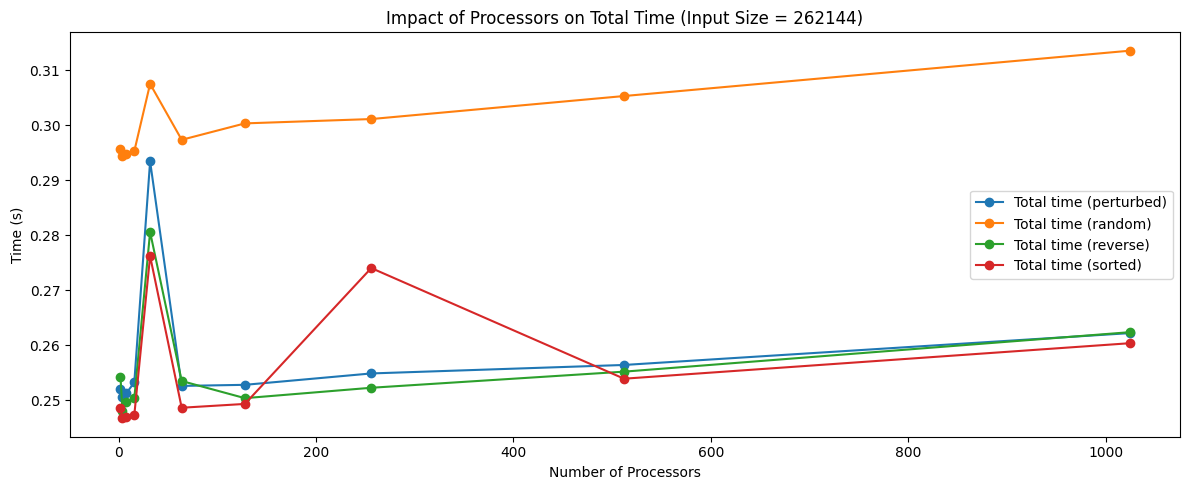

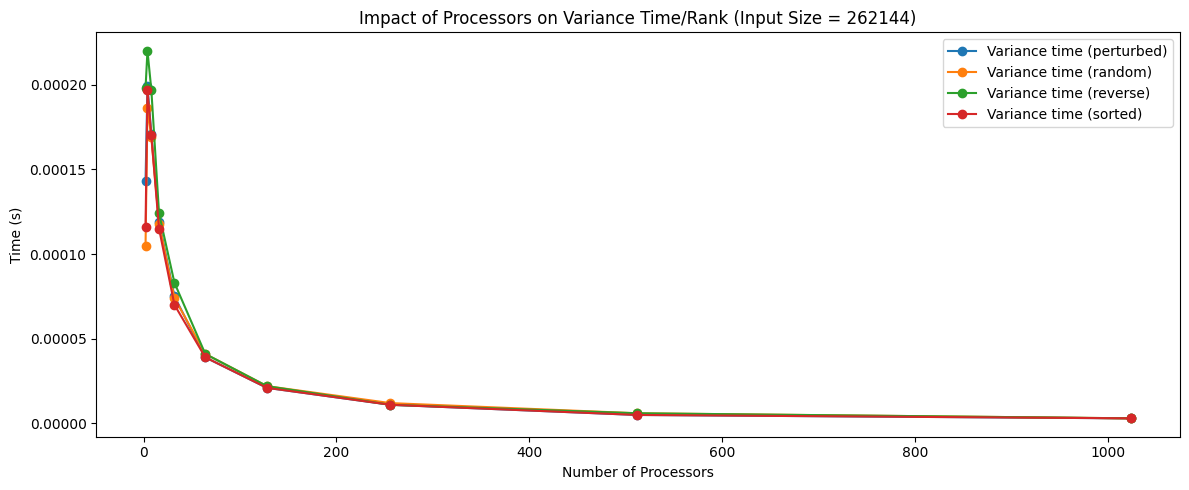

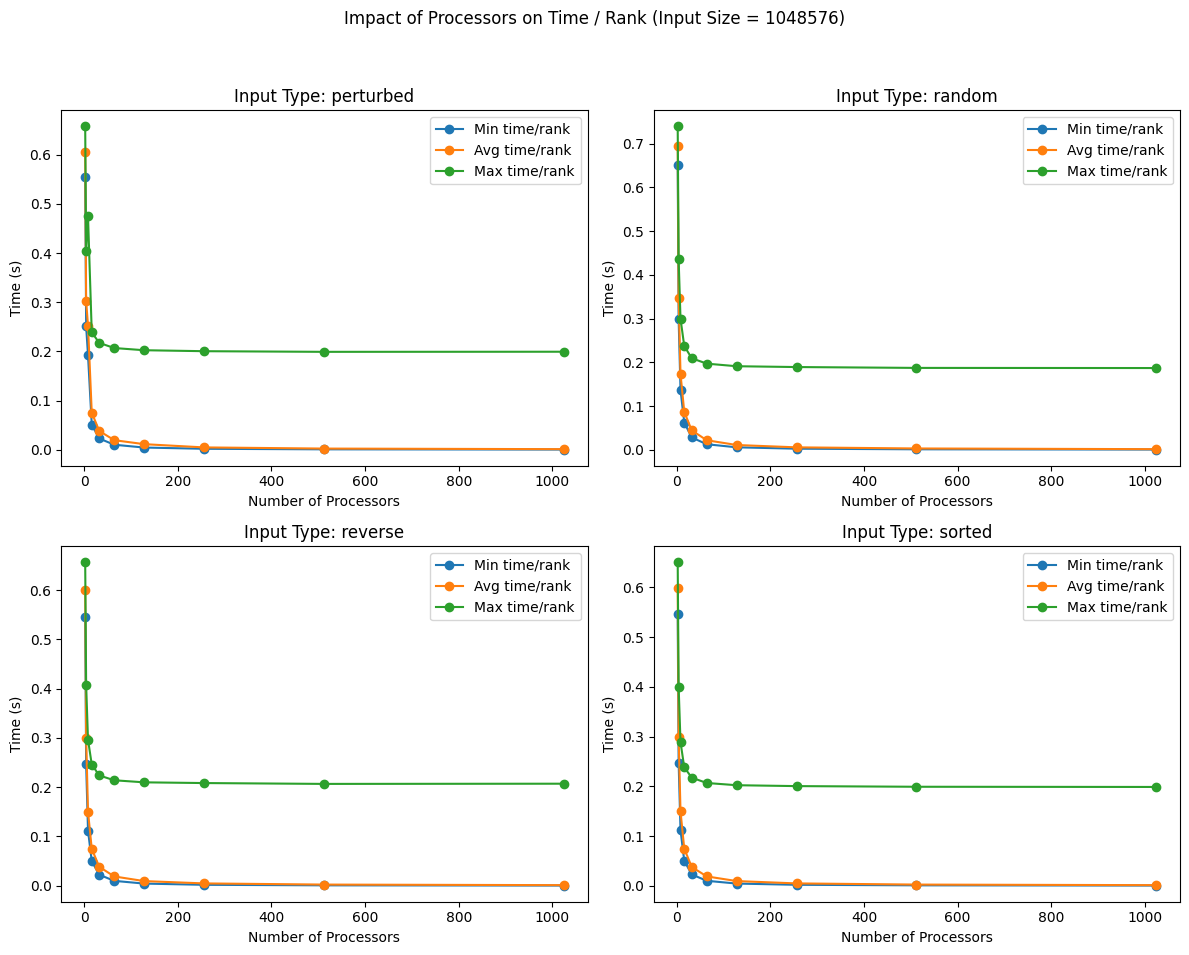

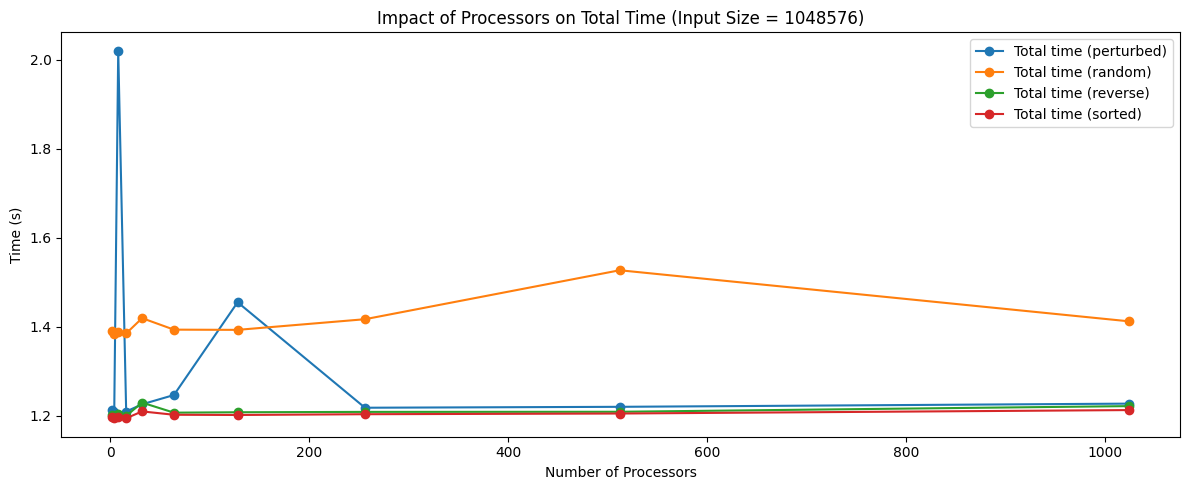

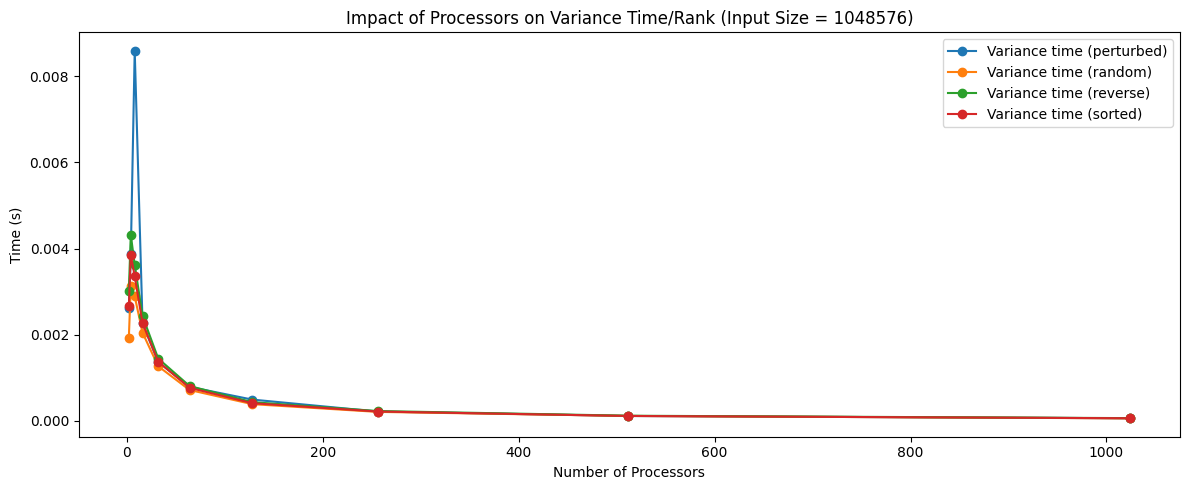

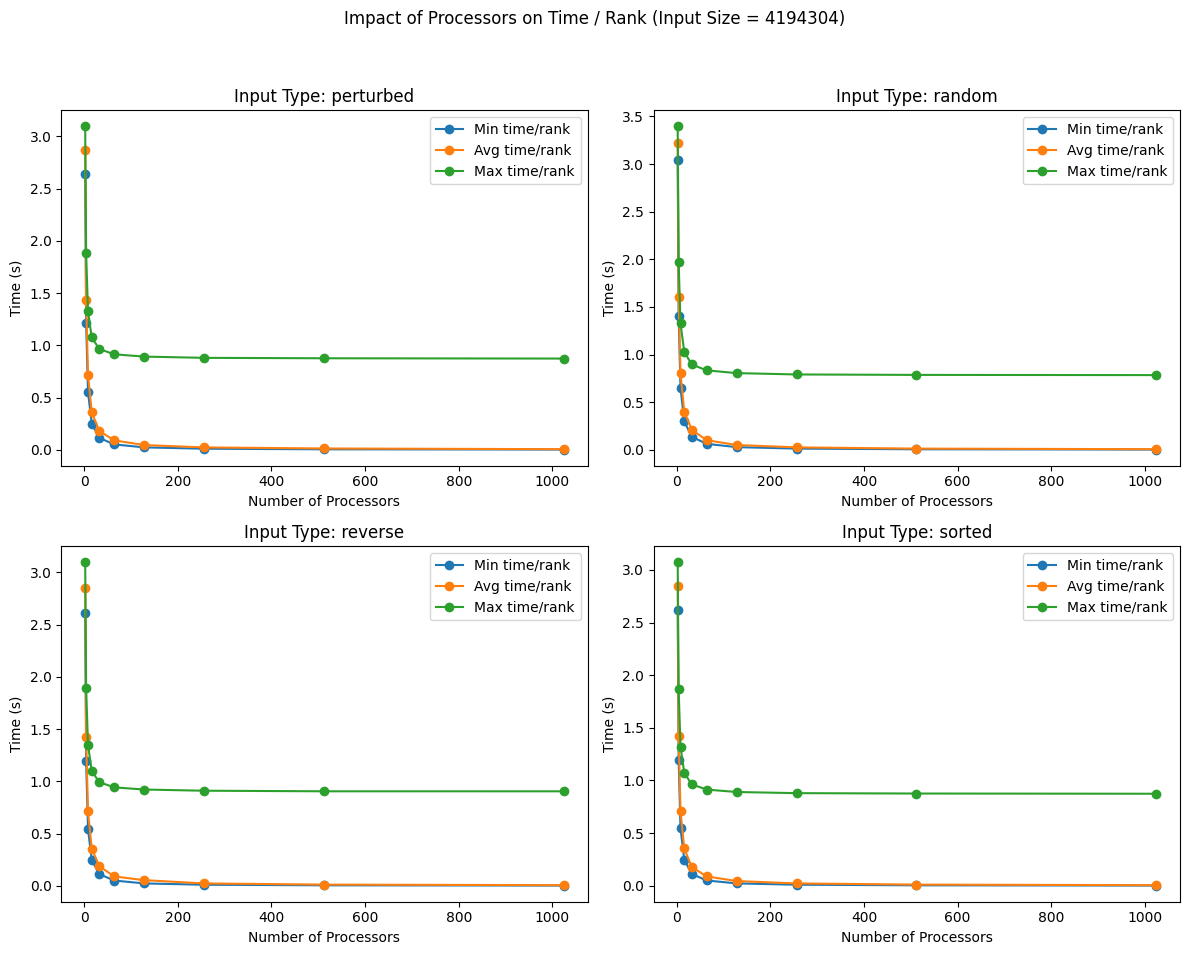

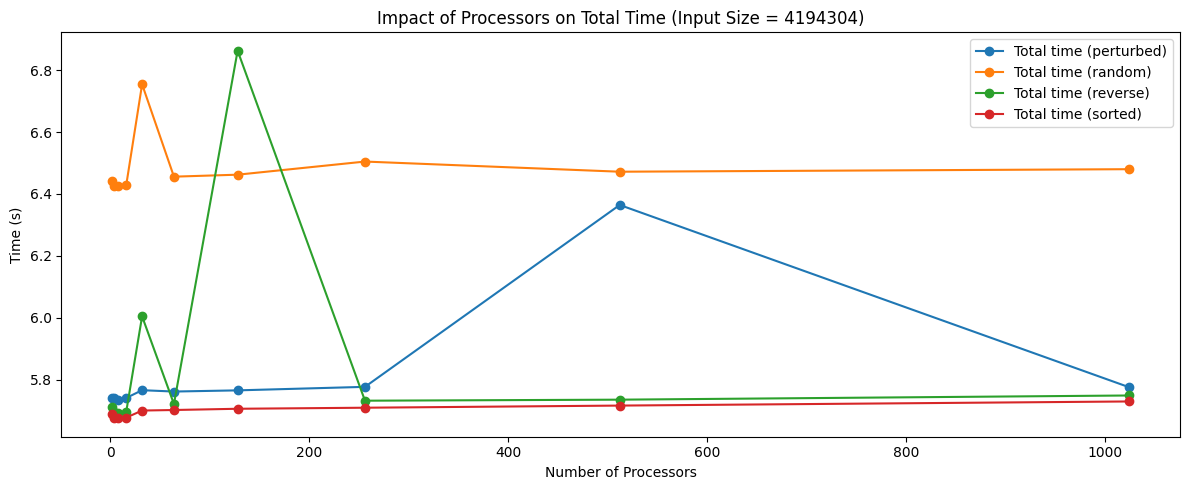

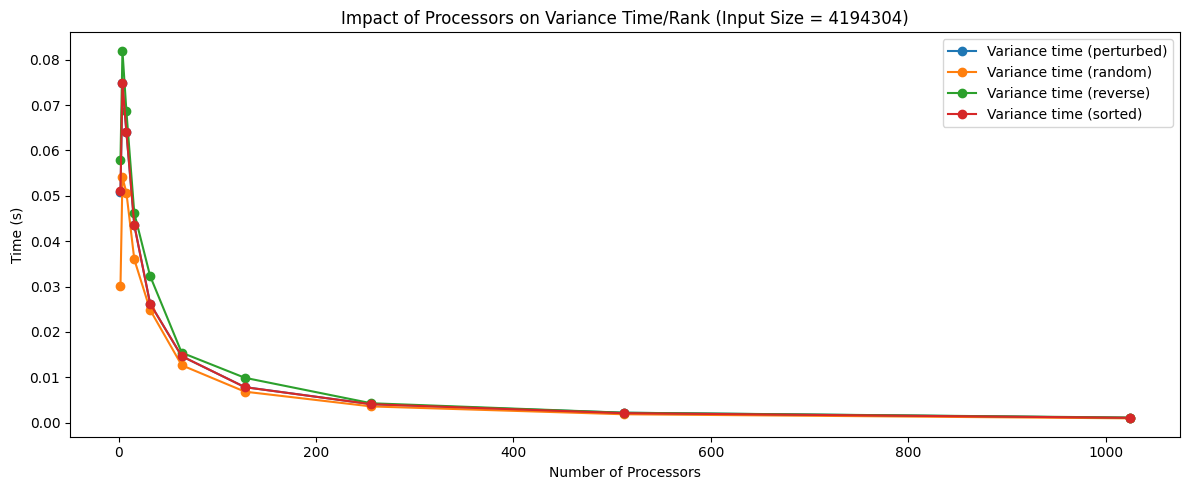

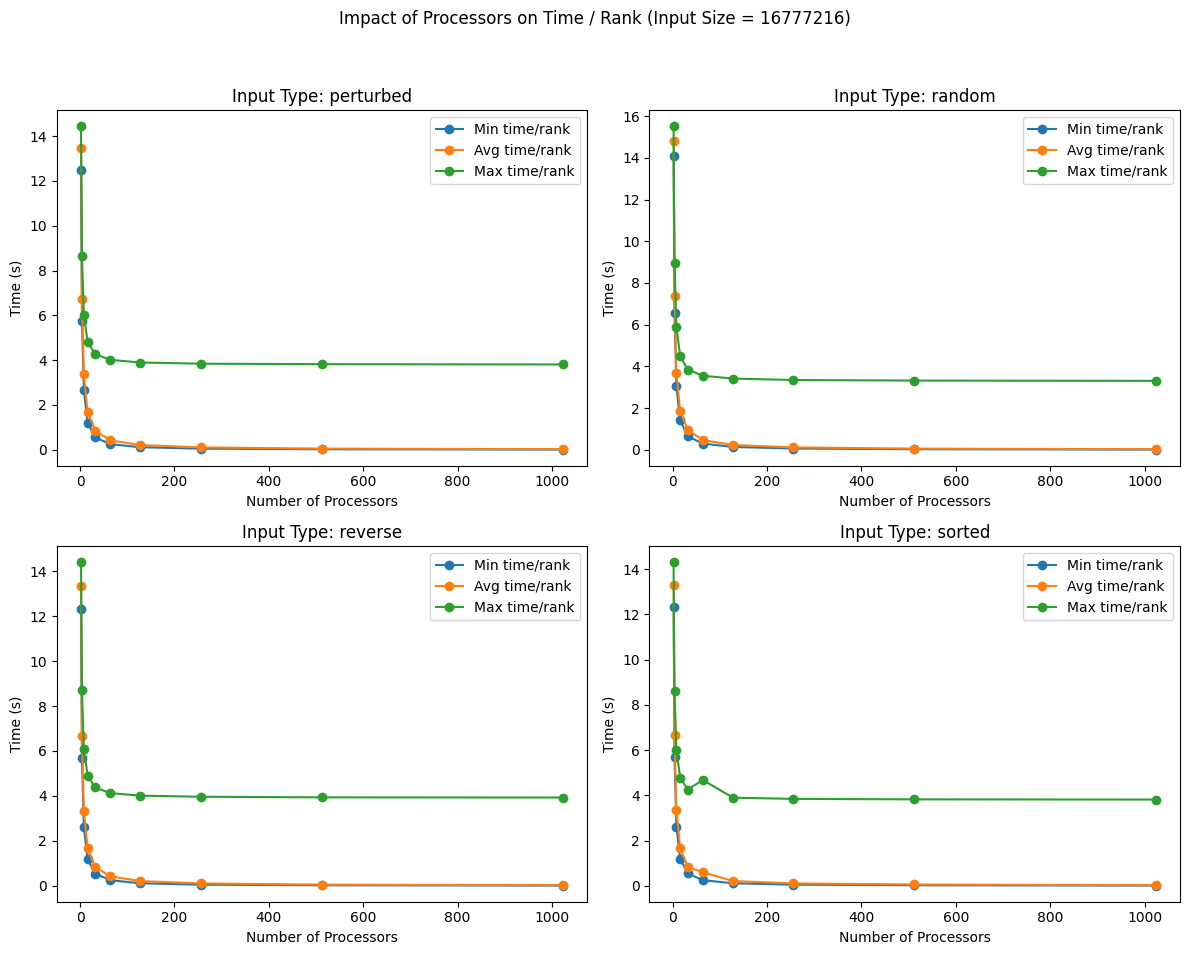

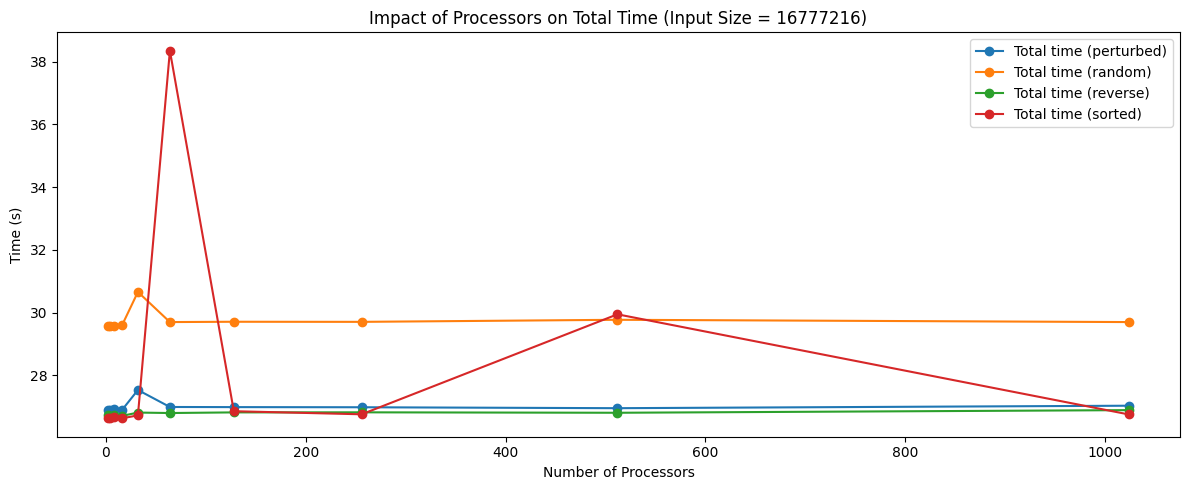

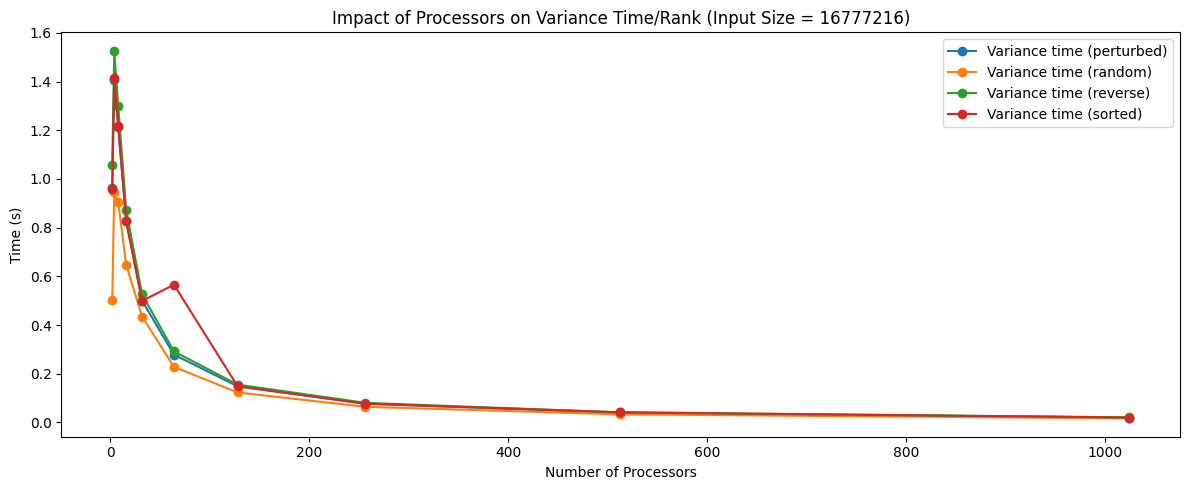

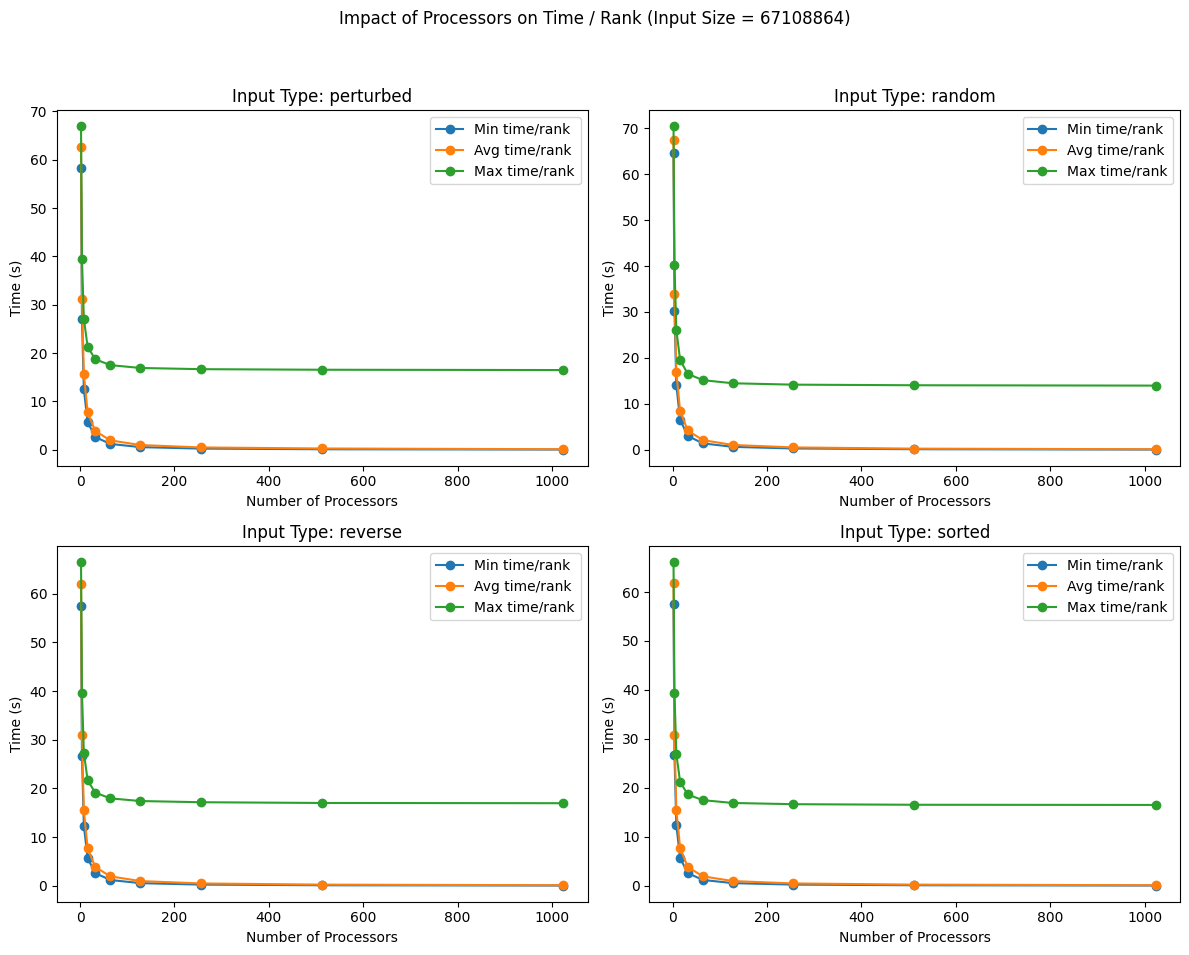

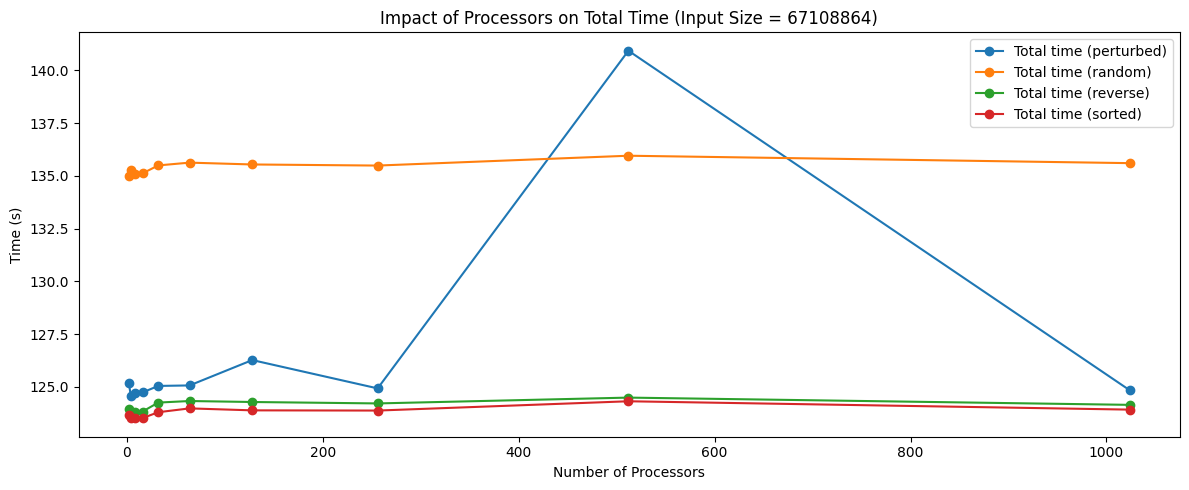

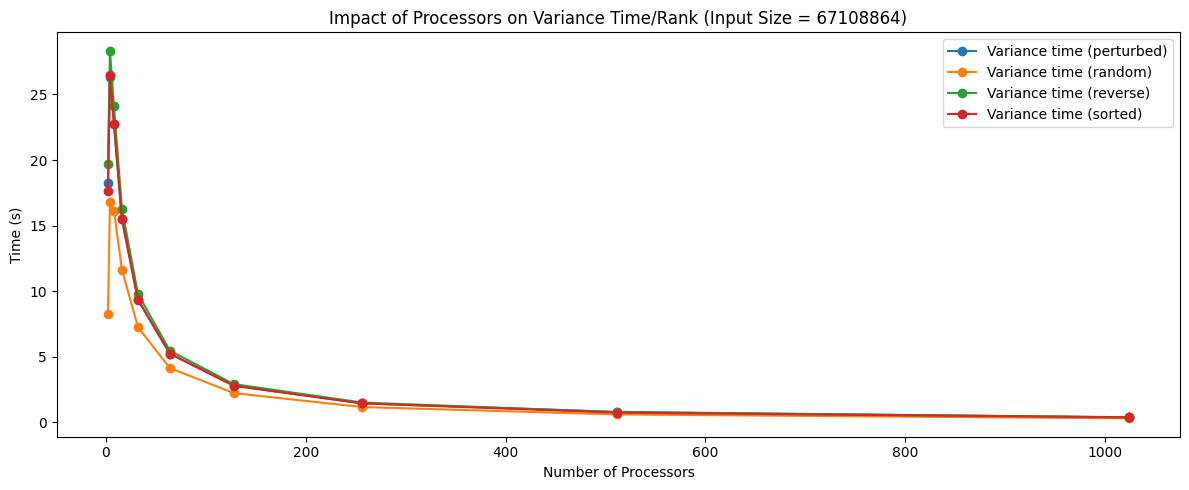

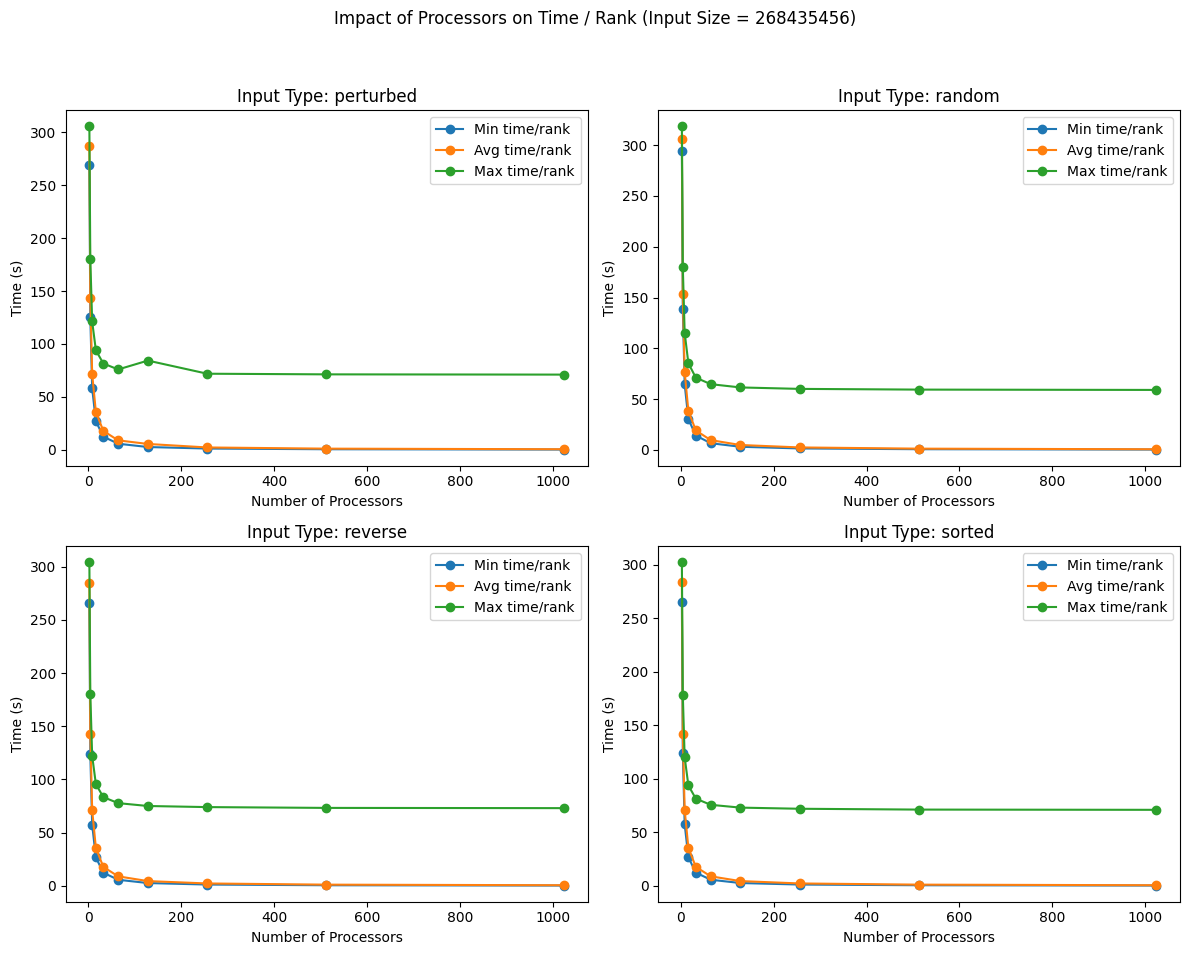

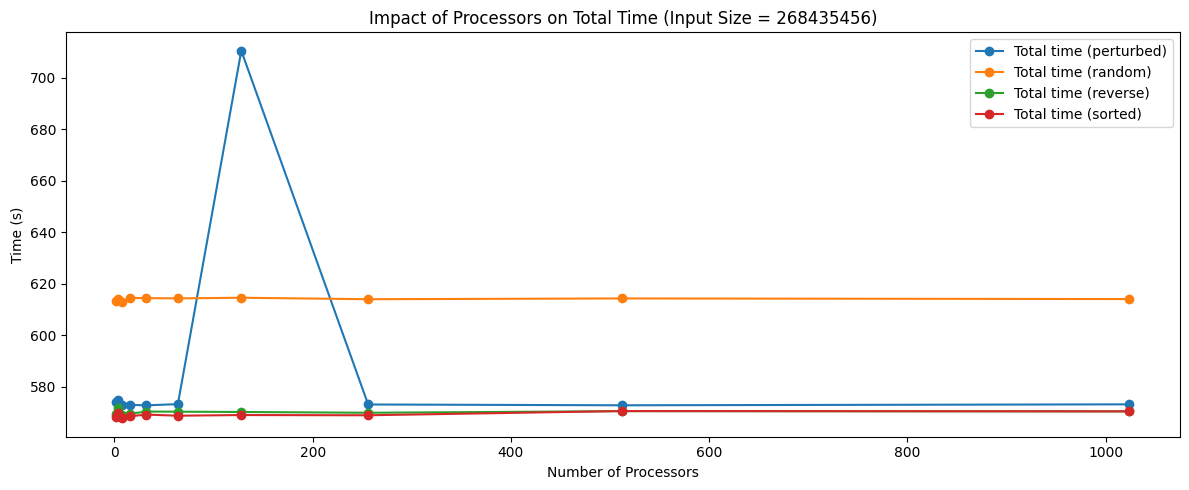

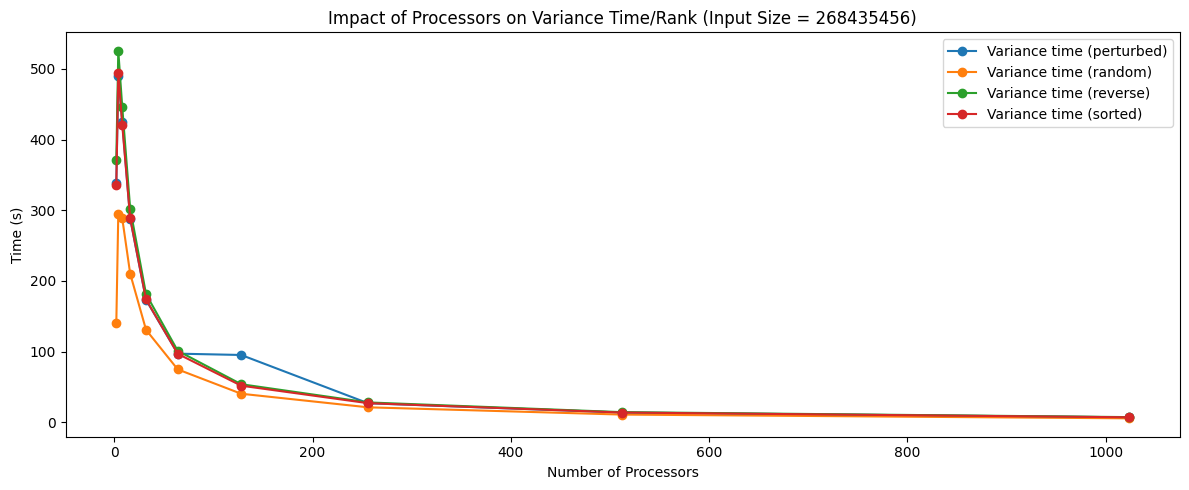

In [18]:
plot_process_performance(perfdata, 'bitonic', show=True, save=True)

As we can see from the above plots, the computation time by rank scales down negative exponentially as expected when we scale up the number of processors. This is because the bitonic sort implementation recursively divides the computational load between processors such that each only has to manage an even subarray. 

We also see that as we increase the input size, the exponential speedup by number of processes is maintained, while our total time does increase. This is expected as greater array sizes means increased computational costs per processor, additional memory allocation, and more data that needs to be communicated between processes. 

Another good indication is that the variance in computational time between processes likewise displays an exponential decay as we ramp up the number of processors. This is good news as it indicates this approach is evenly distributing the workload among processors. The key factor in this is the parallel merging algorithm I implemented that utilizes partner processes to hierarchically merge the locally sorted subarrays, trickling up into the master process's final sorted array.

Overall, the scalability of this approach is definitely quite strong as we ramp up the number of processors and exponentiate our input size, but there is definitely still room for improvement on cutting down communication costs and complexities.